## Importaciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

from ipywidgets import interact
import plotly.express as px
import ipywidgets as widgets

from sodapy import Socrata
from pytrends.request import TrendReq
#!pip install pytrends

In [2]:
df = pd.read_csv('data/DATOS_ANUALES_H7_colectivos.csv', sep=';',encoding='latin1',decimal=",")

## Contextualizar el dataset

Se pretende estimar los días mensuales de baja por incapacidad temporal (IT) calculados en plantilla equivalente.

La intención es predecir el coste que supondría cubrir al 100% las bajas laborales cada mes hasta el final de año.

Para poder estimar el coste necesitamos dividir nuestros datos en colectivos profesionales porque cada colectivo tiene unas retribuciones particulares marcadas en la tablas retributivas del ICS.

Usamos la clasificación de categorias usadas en un proyecto anterior (PR05) y examinamos los contratos formalizados para cubrir bajas por IT:
<img src="imagen1.png">
Vemos que hay 7 colectivos que cubren sus bajas laborales (descartamos enonces los Residentes)

Examinamos el colectivo "Otros":
<img src="imagen2.png">
Vemos que sobretodo se cubren bajas en los subcolectivos de Mantimiento y Hoteleria. Separamos el colectivo Otros en 2 y descartamos los demás.

Antes de importar los datos hemos seleccionado sólo aquellos cuya categoria se incluye en uno de estos 8 colectivos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COLECTIVO                2400 non-null   object 
 1   MES                      2400 non-null   int64  
 2   AÑO                      2400 non-null   int64  
 3   Festivos_intersemanales  2400 non-null   int64  
 4   SumaDePEQ1               2400 non-null   float64
 5   SumaDePEQ_IT             2277 non-null   float64
 6   EDAD_MEDIA               2400 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 131.4+ KB


* Festivos_intersemanales: número de festivos entre semana de un determinado mes.
* SumaDePEQ1: número total de trabajadores calculado en plantilla equivalente
<img src="imagen5.png">
* SumaDePEQ_IT: número total de bajas laborales expresado en plantilla equivalente
<img src="imagen4.png">
* EDAD_MEDIA: Edad promedio de los trabajadores

![](img/imagen3.png)

## First Cleaning

In [4]:
#Añadimos columna en formato fecha
df['date'] = pd.to_datetime(
    dict(
        year=df['AÑO'], 
        month=df['MES'], 
        day=1
    )
)

In [5]:
#Limitamos datos a los históricos
df = df[(df['date'] < "2022-02-01")]

In [6]:
#Limitamos datos a los colectivos que cubren sus bajas IT con sustituciones
df=df[(df['COLECTIVO']!='Otros')&(df['COLECTIVO']!='Residentes/as')]

In [7]:
#Rellenamos valores nulos por 0
df=df.fillna(0)

#Renombramos columnas
df=df.rename(columns={'SumaDePEQ1':'Plantilla','SumaDePEQ_IT':'Plantilla_de_baja','EDAD_MEDIA':'Edad_promedio'})

#Ordenamos dataframe por date
df=df.sort_values(by=['COLECTIVO','date'])

In [8]:
#Repaso dataset limpiado
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 73 to 2388
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   COLECTIVO                1832 non-null   object        
 1   MES                      1832 non-null   int64         
 2   AÑO                      1832 non-null   int64         
 3   Festivos_intersemanales  1832 non-null   int64         
 4   Plantilla                1832 non-null   float64       
 5   Plantilla_de_baja        1832 non-null   float64       
 6   Edad_promedio            1832 non-null   float64       
 7   date                     1832 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 128.8+ KB


## Primera exploración

In [9]:
#Gráfico interactivo para comparar la evolución temporal de las diferentes variables
@interact(Colectivo=df['COLECTIVO'].unique().tolist(),Variable_Y=['Plantilla_de_baja', 'Plantilla',
       'Edad_promedio','Festivos_intersemanales'],Variable_X=['Plantilla', 'Plantilla_de_baja',
       'Edad_promedio','Festivos_intersemanales'])
def lineplot(Colectivo,Variable_Y,Variable_X):
    display(px.line(df[df['COLECTIVO']==Colectivo], x='date',y=[Variable_Y,Variable_X],title=f'{Variable_Y} y {Variable_X} de {Colectivo}'))

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

In [10]:
#Conclusiones
'''
Aparentemente no existe una correlación entre crecimiento de absentismo por IT y crecimiento de plantilla.
Tampoco se observa correlación clara entre crecimiento de absentismo por IT y crecimiento de edad promedio.
Se observa correlación negativa entre crecimiento de plantilla y crecimiento de edad promedio.
'''

'\nAparentemente no existe una correlación entre crecimiento de absentismo por IT y crecimiento de plantilla.\nTampoco se observa correlación clara entre crecimiento de absentismo por IT y crecimiento de edad promedio.\nSe observa correlación negativa entre crecimiento de plantilla y crecimiento de edad promedio.\n'

## Añadir nuevas variables

### Datos de incidencia COVID en Área de Salud de Badalona

In [12]:
#Accedo a la información con método Socrata y parámetros:
with open('./token.txt') as f:
    token=f.read()
with open('./password_api.txt') as f:
    password_api=f.read()  

client = Socrata("analisi.transparenciacatalunya.cat",
                  token,
                  username="carlosrsir@gmail.com",
                  password=password_api)
 

#Utilizo el método de Socrata client.get y amplio el límite a 100000 registros 
#Filtro por sector sanitario que agrupa los alrededores de Badalona
results = client.get("xuwf-dxjd",order='data DESC',limit=100000,where='sectorsanitaricodi="7867"')
#Obtengo un json llamado “results” y lo transformo en df
covid_abs_badalona=pd.json_normalize(results)
covid_abs_badalona.info()
'''Se debe transformar el campo "data" a un campo válido de fecha'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58272 entries, 0 to 58271
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   data                      58272 non-null  object
 1   regiosanitariacodi        58272 non-null  object
 2   regiosanitariadescripcio  58272 non-null  object
 3   sectorsanitaricodi        58272 non-null  object
 4   sectorsanitaridescripcio  58272 non-null  object
 5   abscodi                   58272 non-null  object
 6   absdescripcio             58272 non-null  object
 7   sexecodi                  58272 non-null  object
 8   sexedescripcio            58272 non-null  object
 9   resultatcoviddescripcio   58272 non-null  object
 10  numcasos                  58272 non-null  object
dtypes: object(11)
memory usage: 4.9+ MB


'Se debe transformar el campo "data" a un campo válido de fecha'

In [13]:
#transformo los datos que luego usaré
covid_abs_badalona['data']=pd.to_datetime(covid_abs_badalona['data'])
covid_abs_badalona['numcasos']=covid_abs_badalona['numcasos'].astype('int')
covid_abs_badalona['año']=pd.DatetimeIndex(covid_abs_badalona['data']).year
covid_abs_badalona['mes']=pd.DatetimeIndex(covid_abs_badalona['data']).month
covid_abs_badalona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58272 entries, 0 to 58271
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   data                      58272 non-null  datetime64[ns]
 1   regiosanitariacodi        58272 non-null  object        
 2   regiosanitariadescripcio  58272 non-null  object        
 3   sectorsanitaricodi        58272 non-null  object        
 4   sectorsanitaridescripcio  58272 non-null  object        
 5   abscodi                   58272 non-null  object        
 6   absdescripcio             58272 non-null  object        
 7   sexecodi                  58272 non-null  object        
 8   sexedescripcio            58272 non-null  object        
 9   resultatcoviddescripcio   58272 non-null  object        
 10  numcasos                  58272 non-null  int32         
 11  año                       58272 non-null  int64         
 12  mes               

In [14]:
#filtramos dataset con sólo los datos que nos interesa:
df_covid=covid_abs_badalona.groupby(['año','mes'])['numcasos'].sum().reset_index()
#echamos un vistazo:
df_covid.head()

,año,mes,numcasos
0,2020,3,2963
1,2020,4,3159
2,2020,5,1289
3,2020,6,683
4,2020,7,2766


In [15]:
# Fusionamos viejo dataset con nuevo dataset:
df=df.rename(columns={"MES": "mes", "AÑO": "año"})
df=df.merge(df_covid,left_on=['mes','año'],right_on=['mes','año'],how='left')
df=df.rename(columns={'numcasos':'casos_covid'})

In [16]:
#Rellenamos valores nulos por 0
df=df.fillna(0)
df.head()

,COLECTIVO,mes,año,Festivos_intersemanales,Plantilla,Plantilla_de_baja,Edad_promedio,date,casos_covid
0,Administrativos/as,1,2003,2,218.677419,17.451613,40.739937,2003-01-01,0.0
1,Administrativos/as,2,2003,1,215.500000,18.928571,41.172224,2003-02-01,0.0
2,Administrativos/as,3,2003,0,210.129032,14.774194,41.546919,2003-03-01,0.0
3,Administrativos/as,4,2003,2,208.666667,15.566667,41.573832,2003-04-01,0.0
4,Administrativos/as,5,2003,1,206.709677,15.387097,41.891405,2003-05-01,0.0


### Datos GoogleTrends

In [17]:
pytrend = TrendReq()

In [18]:
#provide your search terms
kw_list=['Gripe','Grip','Baja laboral','Baja médica','Baixa laboral']

#search interest per region
trend=pytrend.get_historical_interest(kw_list,year_start=2004, month_start=1,day_start=1,year_end=2022, month_end=3,day_end=31, geo='ES-CT',frequency='daily', sleep=0)
trend=trend.reset_index()
trend['año']=pd.DatetimeIndex(trend['date']).year
trend['mes']=pd.DatetimeIndex(trend['date']).month

#Ahora haríamos un groupby para sacar las medias del mes y sumariamos los valores medios mensuales de los 5 términos de busqueda

In [19]:
trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672 entries, 0 to 6671
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           6672 non-null   datetime64[ns]
 1   Gripe          6672 non-null   int32         
 2   Grip           6672 non-null   int32         
 3   Baja laboral   6672 non-null   int32         
 4   Baja médica    6672 non-null   int32         
 5   Baixa laboral  6672 non-null   int32         
 6   isPartial      6672 non-null   bool          
 7   año            6672 non-null   int64         
 8   mes            6672 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int32(5), int64(2)
memory usage: 293.3 KB


<ipython-input-22-44f27d121e10>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



'Se observa que desde octubre de 2005 los datos cambian. Podemos hacer una interpolación de los datos de 2003, 2004 y 2005'

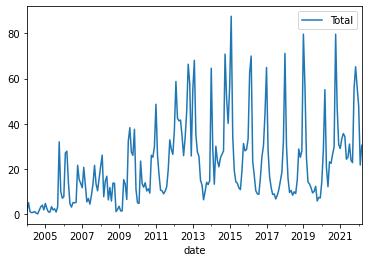

In [22]:
df_googletrends=trend.groupby(['año','mes'])['Gripe','Grip','Baja laboral','Baja médica','Baixa laboral'].mean().reset_index()
df_googletrends['Total']=df_googletrends.drop(['año','mes'],axis=1).sum(axis=1)
df_googletrends['date']=pd.to_datetime(dict(year=df_googletrends['año'],month=df_googletrends['mes'],day=1))
#df_googletrends
df_googletrends.plot(x ='date', y='Total', kind = 'line')
'''Se observa que desde octubre de 2005 los datos cambian. Podemos hacer una interpolación de los datos de 2003, 2004 y 2005'''

In [23]:
df_googletrends=df_googletrends[df_googletrends['date']>'2005-09-01']

<ipython-input-24-0fc7b7b83a16>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='date'>

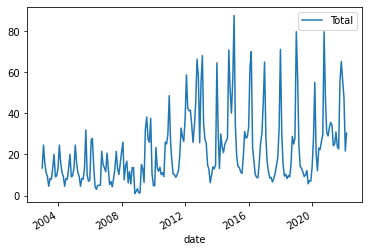

In [24]:
#interpolamos datos 2003,2004 y 2005 a partir de periodo 2006-2008
#2005
datos_interpolados=df_googletrends[(df_googletrends['año']>2005)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2005=datos_interpolados[datos_interpolados['mes']<10]
datos_interpolados_2005['año']=2005
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2005],axis=0)
#df_googletrends.merge(datos_interpolados_2005,left_on=['mes','año','Total'],right_on=['mes','año','Total'],how='left')
#2004
datos_interpolados=df_googletrends[(df_googletrends['año']>2004)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2004=datos_interpolados
datos_interpolados_2004['año']=2004
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2004],axis=0)
#2003
datos_interpolados=df_googletrends[(df_googletrends['año']>2003)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2003=datos_interpolados
datos_interpolados_2003['año']=2003
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2003],axis=0)
df_googletrends['date']=pd.to_datetime(dict(year=df_googletrends['año'],month=df_googletrends['mes'],day=1))
df_googletrends.plot(x ='date', y='Total', kind = 'line')

In [25]:
# Fusionamos viejo dataset con nuevos datasets:
df_googletrends=df_googletrends[['date','Total']].rename(columns={'Total':'busquedas_google'})
df=df.merge(df_googletrends,left_on=['date'],right_on=['date'],how='left')


### Cambio normativa bajas laborales

In [26]:
#Añadimos años de cambio de normativa
df['cambio_normativa'] = np.where((df['date'] > "2012-09-01")&(df['date'] < "2018-11-01"), 1, 0)

## Segunda exploración

In [27]:
#Hacerlo interactivo
@interact(Colectivo=df['COLECTIVO'].unique().tolist())
def pairplot(Colectivo):
    display(sns.pairplot(data=df[df.COLECTIVO==Colectivo][['Plantilla','Plantilla_de_baja','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']],
             hue='cambio_normativa'))
'''Se observa correlación entre Plantilla & Plantilla de Baja y Edad & Plantilla y Plantilla de Baja
No se puede ver la correlación COVID & Plantilla de baja porque no está limitado el df a la pandemia'''

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

'Se observa correlación entre Plantilla & Plantilla de Baja y Edad & Plantilla y Plantilla de Baja\nNo se puede ver la correlación COVID & Plantilla de baja porque no está limitado el df a la pandemia'

### Análisis correlación de variables con variable objetivo

In [28]:
#Hacerlo interactivo por los diferentes colectivos
@interact(Colectivo=df['COLECTIVO'].unique().tolist(), método=['spearman','pearson'])
def correlacion(Colectivo,método):
    plt.rcParams['figure.figsize']=(2,5)
    correl=df[(df.COLECTIVO==Colectivo)][['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method=método).iloc[0,:]
    sns.heatmap(correl.to_frame(name=método),annot=True,center=0,cmap='vlag')

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

In [29]:
#Añadir en la exploración un filtro que me delimite el análisis a antes de la pandemia COVID
#Hacerlo interactivo por los diferentes colectivos
@interact(Colectivo=df['COLECTIVO'].unique().tolist(), método=['spearman','pearson'])
def correlacion(Colectivo,método):
    plt.rcParams['figure.figsize']=(2,5)
    correl=df[(df.COLECTIVO==Colectivo)&(df['date'] < "2020-03-01")][['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method=método).iloc[0,:]
    sns.heatmap(correl.to_frame(name=método),annot=True,center=0,cmap='vlag')

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…


* En general las variables 'casos COVID', 'plantilla' & 'busquedas_google' tienen correlación positivas respecto a la variable objetivo
* En general las variables 'Edad_promedio', 'Festivos_intersemanales' & 'cambio_normativa' tienen correlación negativa respecto a la variable objetivo


<AxesSubplot:>

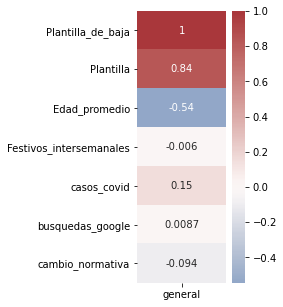

In [33]:
correl=df[['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method='spearman').iloc[0,:]
sns.heatmap(correl.to_frame(name='general'),annot=True,center=0,cmap='vlag')

### Análisis coliniaridad entre variables

<AxesSubplot:>

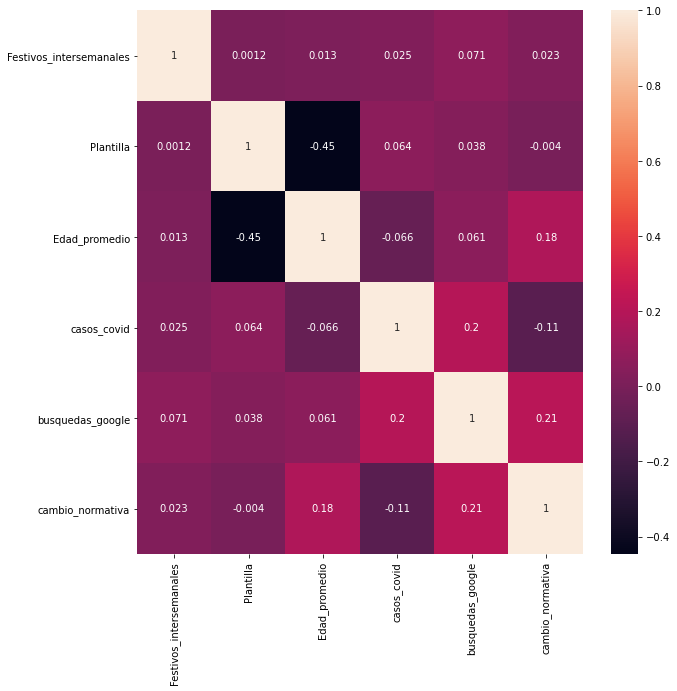

In [51]:
#Vemos que hay una correlación negativa entre edad_promedio & Plantilla (Los meses en los que no se contratan nuevos trabajadores la plantilla se envejece)
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df.select_dtypes('number').drop(['mes','año','Plantilla_de_baja'],axis=1).corr(),annot=True)

In [52]:
#Analisis de coliniaridad con VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
X = sm.add_constant(df.select_dtypes('number').drop(['mes','año','Plantilla_de_baja'],axis=1))
pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns.to_list()[1:]) 

Festivos_intersemanales    1.005391
Plantilla                  1.264054
Edad_promedio              1.304444
casos_covid                1.074694
busquedas_google           1.116767
cambio_normativa           1.110414
dtype: float64

La variable no presenta mucha coliniaridad pero para eliminar confusión decidimos eliminarla del dataset

In [54]:
X = X.drop(['Edad_promedio'],axis=1)
pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns.to_list()[1:]) 

Festivos_intersemanales    1.005329
Plantilla                  1.004760
casos_covid                1.073540
busquedas_google           1.113628
cambio_normativa           1.075597
dtype: float64

In [69]:
df.drop('Edad_promedio',axis=1,inplace=True)

## Exportación csv

In [66]:
#limpieza previa a exportación
df["COLECTIVO"]=df["COLECTIVO"].str.replace("Personal ","")

In [73]:
#Loop para exportar los datasets resultantes
for c in df['COLECTIVO'].unique().tolist():
    df[df['COLECTIVO']==c].reset_index().to_csv(f"output\{c[0:5]}.csv",encoding='latin-1',index=False)
